# Preliminary

In [30]:
import tensorflow as tf
import tensorflow_addons as tfa #this had to be installed from github
import tensorflow.keras as keras
import sys
import pickle, random, string
import matplotlib.pyplot as plt
from pathlib import Path #for nicely dealing with Paths

In [31]:
# Ugly patch becasue idk how to make this propperly work
# sys.path[0] += '/Codebase'
sys.path

['/home/jovyan/Extrapolation-Exploration/Codebase/Codebase',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/opt/conda/lib/python3.9/site-packages']

In [32]:
#my classes
#from testClass import *
from transformerClasses import *
from embeddingClasses import *
from lstmClasses import *
from resourceFunctions import *

# Loading Outer Model

In [33]:
# setting up the pathlib stuff 
path = Path('..')
print([x for x in path.iterdir() if x.is_dir()])

path = path / 'saved-models'
outPath = path / 'OuterTransformer'

encPathJson = outPath / 'encoder_len53.json'
decPathJson = outPath / 'decoder_len53.json'
encPathH5 = outPath / 'encoder_len53.h5'
decPathH5 = outPath / 'decoder_len53.h5'

[PosixPath('../.ipynb_checkpoints'), PosixPath('../saved-models'), PosixPath('../Qualifying-Exam-Writings'), PosixPath('../Codebase'), PosixPath('../data'), PosixPath('../.git')]


In [34]:
with encPathJson.open() as encFile, decPathJson.open() as decFile:
    encJson = encFile.read()
    decJson = decFile.read()
    
outer_encoder = keras.models.model_from_json(encJson, 
                                            custom_objects={"PositionEmbedding":OuterPositionEmbedding,
                                                            "TransformerBlock":OuterTransformerBlock,
                                                            "MaskedTokenAndPositionEmbedding": OuterMaskedTokenAndPositionEmbedding, 
                                                            "MaskedTransformerBlock":OuterMaskedTransformerBlock})
outer_decoder = keras.models.model_from_json(decJson, 
                                             custom_objects={"PositionEmbedding":OuterPositionEmbedding,
                                                             "TransformerBlock":OuterTransformerBlock,
                                                             "MaskedTokenAndPositionEmbedding": OuterMaskedTokenAndPositionEmbedding, 
                                                             "MaskedTransformerBlock":OuterMaskedTransformerBlock})
outer_encoder.load_weights(encPathH5)
outer_decoder.load_weights(decPathH5)

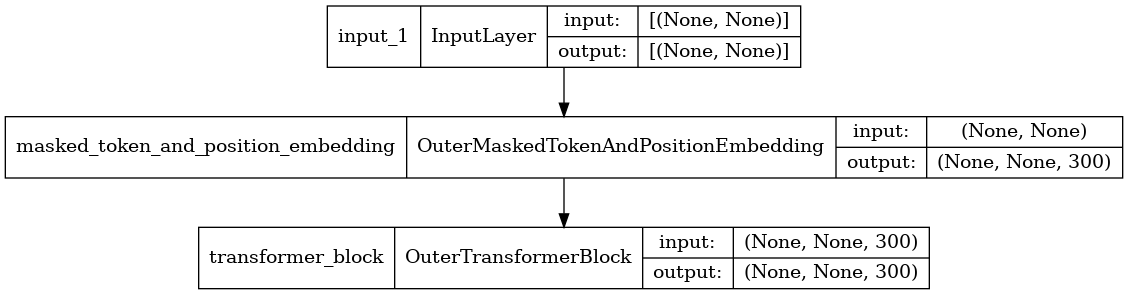

In [6]:
keras.utils.plot_model(outer_encoder, show_shapes=True)

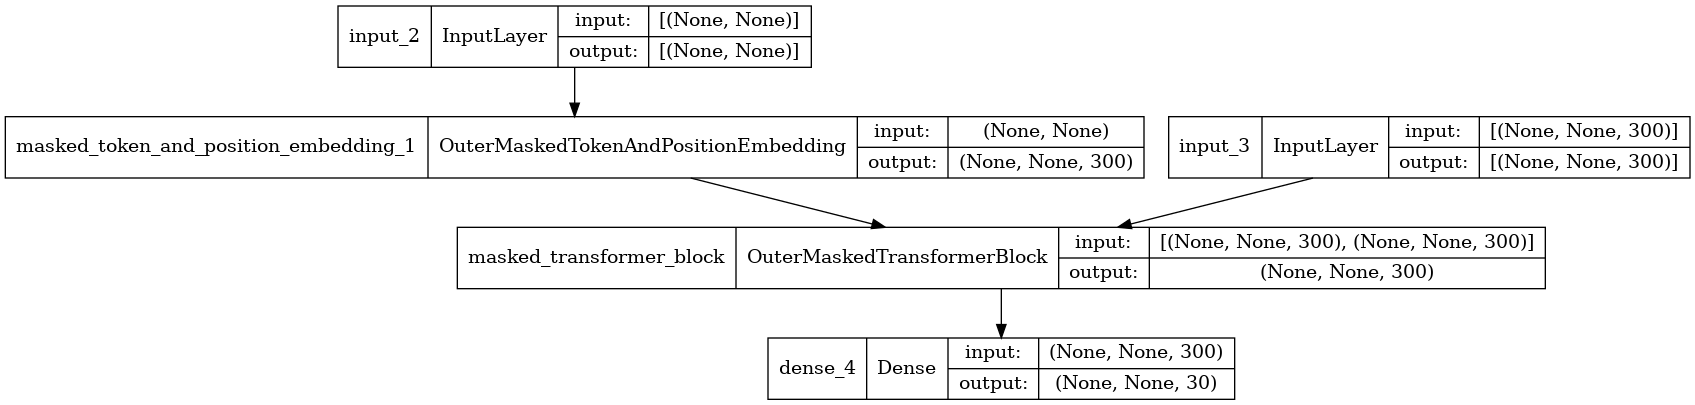

In [7]:
keras.utils.plot_model(outer_decoder, show_shapes=True)

# Training and Testing Data

In [8]:
# Load training and testing data

# corpus = np.loadtxt(sys.argv[1], dtype=object)
# trainingSet = np.loadtxt(sys.argv[2], dtype=object)
# testingSet  = np.loadtxt(sys.argv[3], dtype=object)


#corpus = np.loadtxt(sys.argv[1], dtype=object)
corpus = (Path('..') / 'data' / 'len5_10000-train.txt' ).open() #open('../data/len5_10000-train.txt')
corpus = np.loadtxt(corpus, dtype=object)

trainingSet = (Path('..') / 'data' / 'SG-10-train.txt').open()
testingSet  = (Path('..') / 'data' / 'SG-10-test.txt').open()

trainingSet = np.loadtxt(trainingSet, dtype=str)
testingSet  = np.loadtxt(testingSet, dtype=str)

# Create Embeddings

In [9]:
# --- Create embeddings ---
X, Y, preY, postY, mapping = letter_to_int(corpus)

In [28]:
#sample 10 indices from the coprus WOR
corIdx = np.random.randint(0,high=len(corpus),size=20)
#I could probably just do a np array of size 10000 
corIdx = np.random.choice(corIdx,size=10,replace=False)

outer_x = X[corIdx]
outer_preY = preY[corIdx]
outer_postY = postY[corIdx]

outer_embeddings = outer_encoder.predict(outer_x)

trainingSet_int = letter_to_int(trainingSet)[0]

testingSet_int = letter_to_int(testingSet)[0]

inner_x = np.array([outer_embeddings[trainingSet_int[x]-1] for x in range(len(trainingSet))]) #200 comes from the trainingSet 
inner_x_testing = np.array([outer_embeddings[testingSet_int[x]-1] for x in range(len(testingSet))])

In [29]:
outer_embeddings

array([[[ 1.13430049e-03, -4.91758576e-04,  1.43471345e-01, ...,
          9.36496479e-04,  1.01413450e-03,  1.01763732e-03],
        [ 2.78714200e-04, -2.73020309e-03, -1.62270799e-01, ...,
          3.78769873e-05,  1.10367619e-04,  7.95489817e-04],
        [ 2.30877296e-04, -3.39330960e-04, -1.22251987e-01, ...,
          1.77173672e-04,  2.21059643e-04,  9.41050064e-04],
        [-4.88532474e-04, -1.49263931e-03,  1.71200827e-01, ...,
         -5.46615222e-04, -3.02139524e-04, -5.87185845e-04],
        [-7.14183319e-04,  1.98295573e-03, -3.45096916e-01, ...,
         -1.20749371e-03, -8.43002228e-04, -9.86736384e-04]],

       [[ 9.80242505e-04, -5.69564407e-04,  1.27906084e-01, ...,
          8.26682313e-04,  9.17737489e-04,  9.33600473e-04],
        [ 1.28480257e-04, -2.82497052e-03, -1.78439468e-01, ...,
         -6.63244427e-05,  1.76619724e-05,  7.19967647e-04],
        [ 1.24505640e-03,  1.40105211e-03,  2.33507506e-03, ...,
          6.87588006e-04,  8.27002572e-04, -7.42085

In [11]:
#need testing inner_postY_testing
dog = np.zeros((1,5,300))
dog.shape
np.concatenate((dog, inner_x[0]))

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.10919320e-03,  1.18547305e-03, -1.85422555e-01, ...,
          8.25033756e-04,  9.29467089e-04,  3.28727416e-04],
        [-5.37360727e-04, -2.59209960e-03,  1.63871005e-01, ...,
         -1.05527567e-03, -8.30590900e-04, -1.61972211e-03],
        [ 7.60949973e-04,  1.57007191e-03,  3.33054930e-01, ...,
          5.46373485e-04,  6.91850204e-04,  1.96979

In [12]:
#make inner_postY and outer_postY
dog = np.zeros((1,5,300))
inner_preY = np.array([np.concatenate((dog,inner_x[i])) for i in range(len(inner_x))])
inner_postY = np.array([np.concatenate((inner_x[i],dog)) for i in range(len(inner_x))])

In [13]:
#testing postY and preY
dog = np.zeros((1,5,300))
dog.shape
np.concatenate((dog, inner_x_testing[0]))

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 8.97813763e-04, -3.88563983e-03,  7.45905284e-03, ...,
          9.09143826e-04,  8.96788784e-04,  1.68848829e-03],
        [ 7.86454882e-04, -4.94617224e-03,  1.70429721e-01, ...,
          1.64400175e-04,  3.25726287e-04,  1.09445682e-04],
        [ 1.98764238e-03,  4.12756670e-03,  7.20619559e-02, ...,
          1.18732115e-03,  1.33972953e-03,  2.44347

In [14]:
dog = np.zeros((1,5,300))
inner_preY_testing = np.array([np.concatenate((dog,inner_x_testing[i])) for i in range(len(inner_x_testing))])
inner_postY_testing = np.array([np.concatenate((inner_x_testing[i],dog)) for i in range(len(inner_x_testing))])


In [15]:
# --- Make start and stop tokens ---
s_s = {"start":[1,0],"stop":[0,1], "none":[0,0]}
pre_start = np.zeros((inner_x.shape[0], 4, 2))
post_stop = np.zeros((inner_x.shape[0], 4, 2))
pre_start[:,0,:] = s_s["start"]
post_stop[:,3,:] = s_s["stop"]

# Model stuff

In [16]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [17]:
# --- Model parameters ---
length = 10
padded_length = 20

In [18]:
# Note we are making these the same, but they don't -have- to be!
input_length = padded_length
output_length = padded_length

In [19]:
# Vocabulary sizes...
encoder_vocab_size = 30 # a, b, c, ... z, start, stop, STARTSENTENCE, STOPSENTENCE
decoder_vocab_size = 30 # a, b, c, ... z, start, stop, STARTSENTENCE, STOPSENTENCE

In [20]:
# Size of the gestalt, context representations...
embed_dim = 128  # Embedding size for each token (enc/dec inputs already embedded)
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
stack = 1
wd = 0.01

In [21]:
HIDDEN_SIZE = 300
BATCH_SIZE  = 50
EPOCHS      = 250

# Construct Inner encoder/decoder

In [22]:
# --- Construct inner encoder/decoder ---
with strategy.scope():
    # Encoder
    encoder_input = keras.layers.Input(shape=(None,) + inner_x.shape[2:], name="inner_enc_token")

    encoder_reshape = keras.layers.Reshape((-1,1500))(encoder_input)

    encoder_embedding = keras.layers.Dense(embed_dim)(encoder_reshape)

    encoder_mask_pos_embedding = InnerMaskedPositionEmbedding(maxlen=input_length,
                                                         embed_dim=encoder_embedding.shape[-1])(encoder_embedding)

    encoder_state = InnerTransformerBlock(embed_dim=encoder_embedding.shape[-1],
                                     num_heads=num_heads,
                                     ff_dim=ff_dim)(encoder_mask_pos_embedding)
    encoder_model = keras.Model(encoder_input,encoder_state,name="InnerEncoder")

    # Decoder
    decoder_input = keras.layers.Input(shape=(None,) + inner_preY.shape[2:], name="inner_dec_token")

    decoder_context_input = keras.layers.Input(shape=encoder_state.shape[1:], name='inner_enc_state')

    decoder_reshape = keras.layers.Reshape((-1,1500))(decoder_input)

    decoder_startstop = keras.layers.Input(shape=(None, 2), name="dec_start/stop")

    decoder_inputs = [decoder_context_input, decoder_input, decoder_startstop]

    decoder_concat = keras.layers.Concatenate()([decoder_reshape, decoder_startstop])

    decoder_embedding = keras.layers.Dense(embed_dim)(decoder_concat)

    decoder_mask_pos_embedding = InnerMaskedPositionEmbedding(maxlen=inner_preY.shape[1],
                                                         embed_dim=decoder_embedding.shape[-1])(decoder_embedding)

    decoder_block = InnerMaskedTransformerBlock(embed_dim=decoder_mask_pos_embedding.shape[-1],
                                           num_heads=num_heads,
                                           ff_dim=ff_dim)

    decoder_hidden_output = decoder_block([decoder_mask_pos_embedding, decoder_context_input])

    x = keras.layers.Dense(inner_postY.shape[2]*embed_dim)(decoder_hidden_output)

    inner_output_reshape = keras.layers.Reshape((-1,inner_postY.shape[-2],embed_dim))(x)

    decoder_dense_t1 = keras.layers.Dense(inner_postY.shape[-1], activation='linear', name="output_token")(inner_output_reshape)

    decoder_dense_startstop = keras.layers.Dense(2, activation='sigmoid', name="start/stop")(decoder_hidden_output)

    decoder_outputs = [decoder_dense_t1, decoder_dense_startstop]

    decoder_model = keras.Model(decoder_inputs,decoder_outputs,name="InnerDecoder")
    
    # Tie encoder and decoder into one model
    #with strategy.scope():
    #model = keras.Model([encoder_input]+ decoder_inputs, decoder_outputs)
    coupled_inputs = [keras.layers.Input(encoder_model.inputs[0].shape[1:]),
                      keras.layers.Input(decoder_model.inputs[1].shape[1:]),
                      keras.layers.Input(decoder_model.inputs[2].shape[1:])]                     
    coupled_outputs = decoder_model([encoder_model(coupled_inputs[0])] + coupled_inputs[1:])
    model = keras.Model(coupled_inputs, coupled_outputs)

    # --- Compile and fit model ---
    model.compile(loss = [keras.losses.MSE,keras.losses.binary_crossentropy],
               optimizer=keras.optimizers.Adam(),
               metrics=['accuracy'])

    model_input = {"inner_enc_token":inner_x, "inner_dec_token":inner_preY,
                         "dec_start/stop":pre_start}
    model_target = {"output_token":inner_postY, "start/stop": post_stop}

    #with strategy.scope():
    history = model.fit([inner_x,inner_preY, pre_start], [inner_postY,post_stop],
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         verbose=0)


2022-07-31 19:22:45.489914: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2929"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:17"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 50
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You

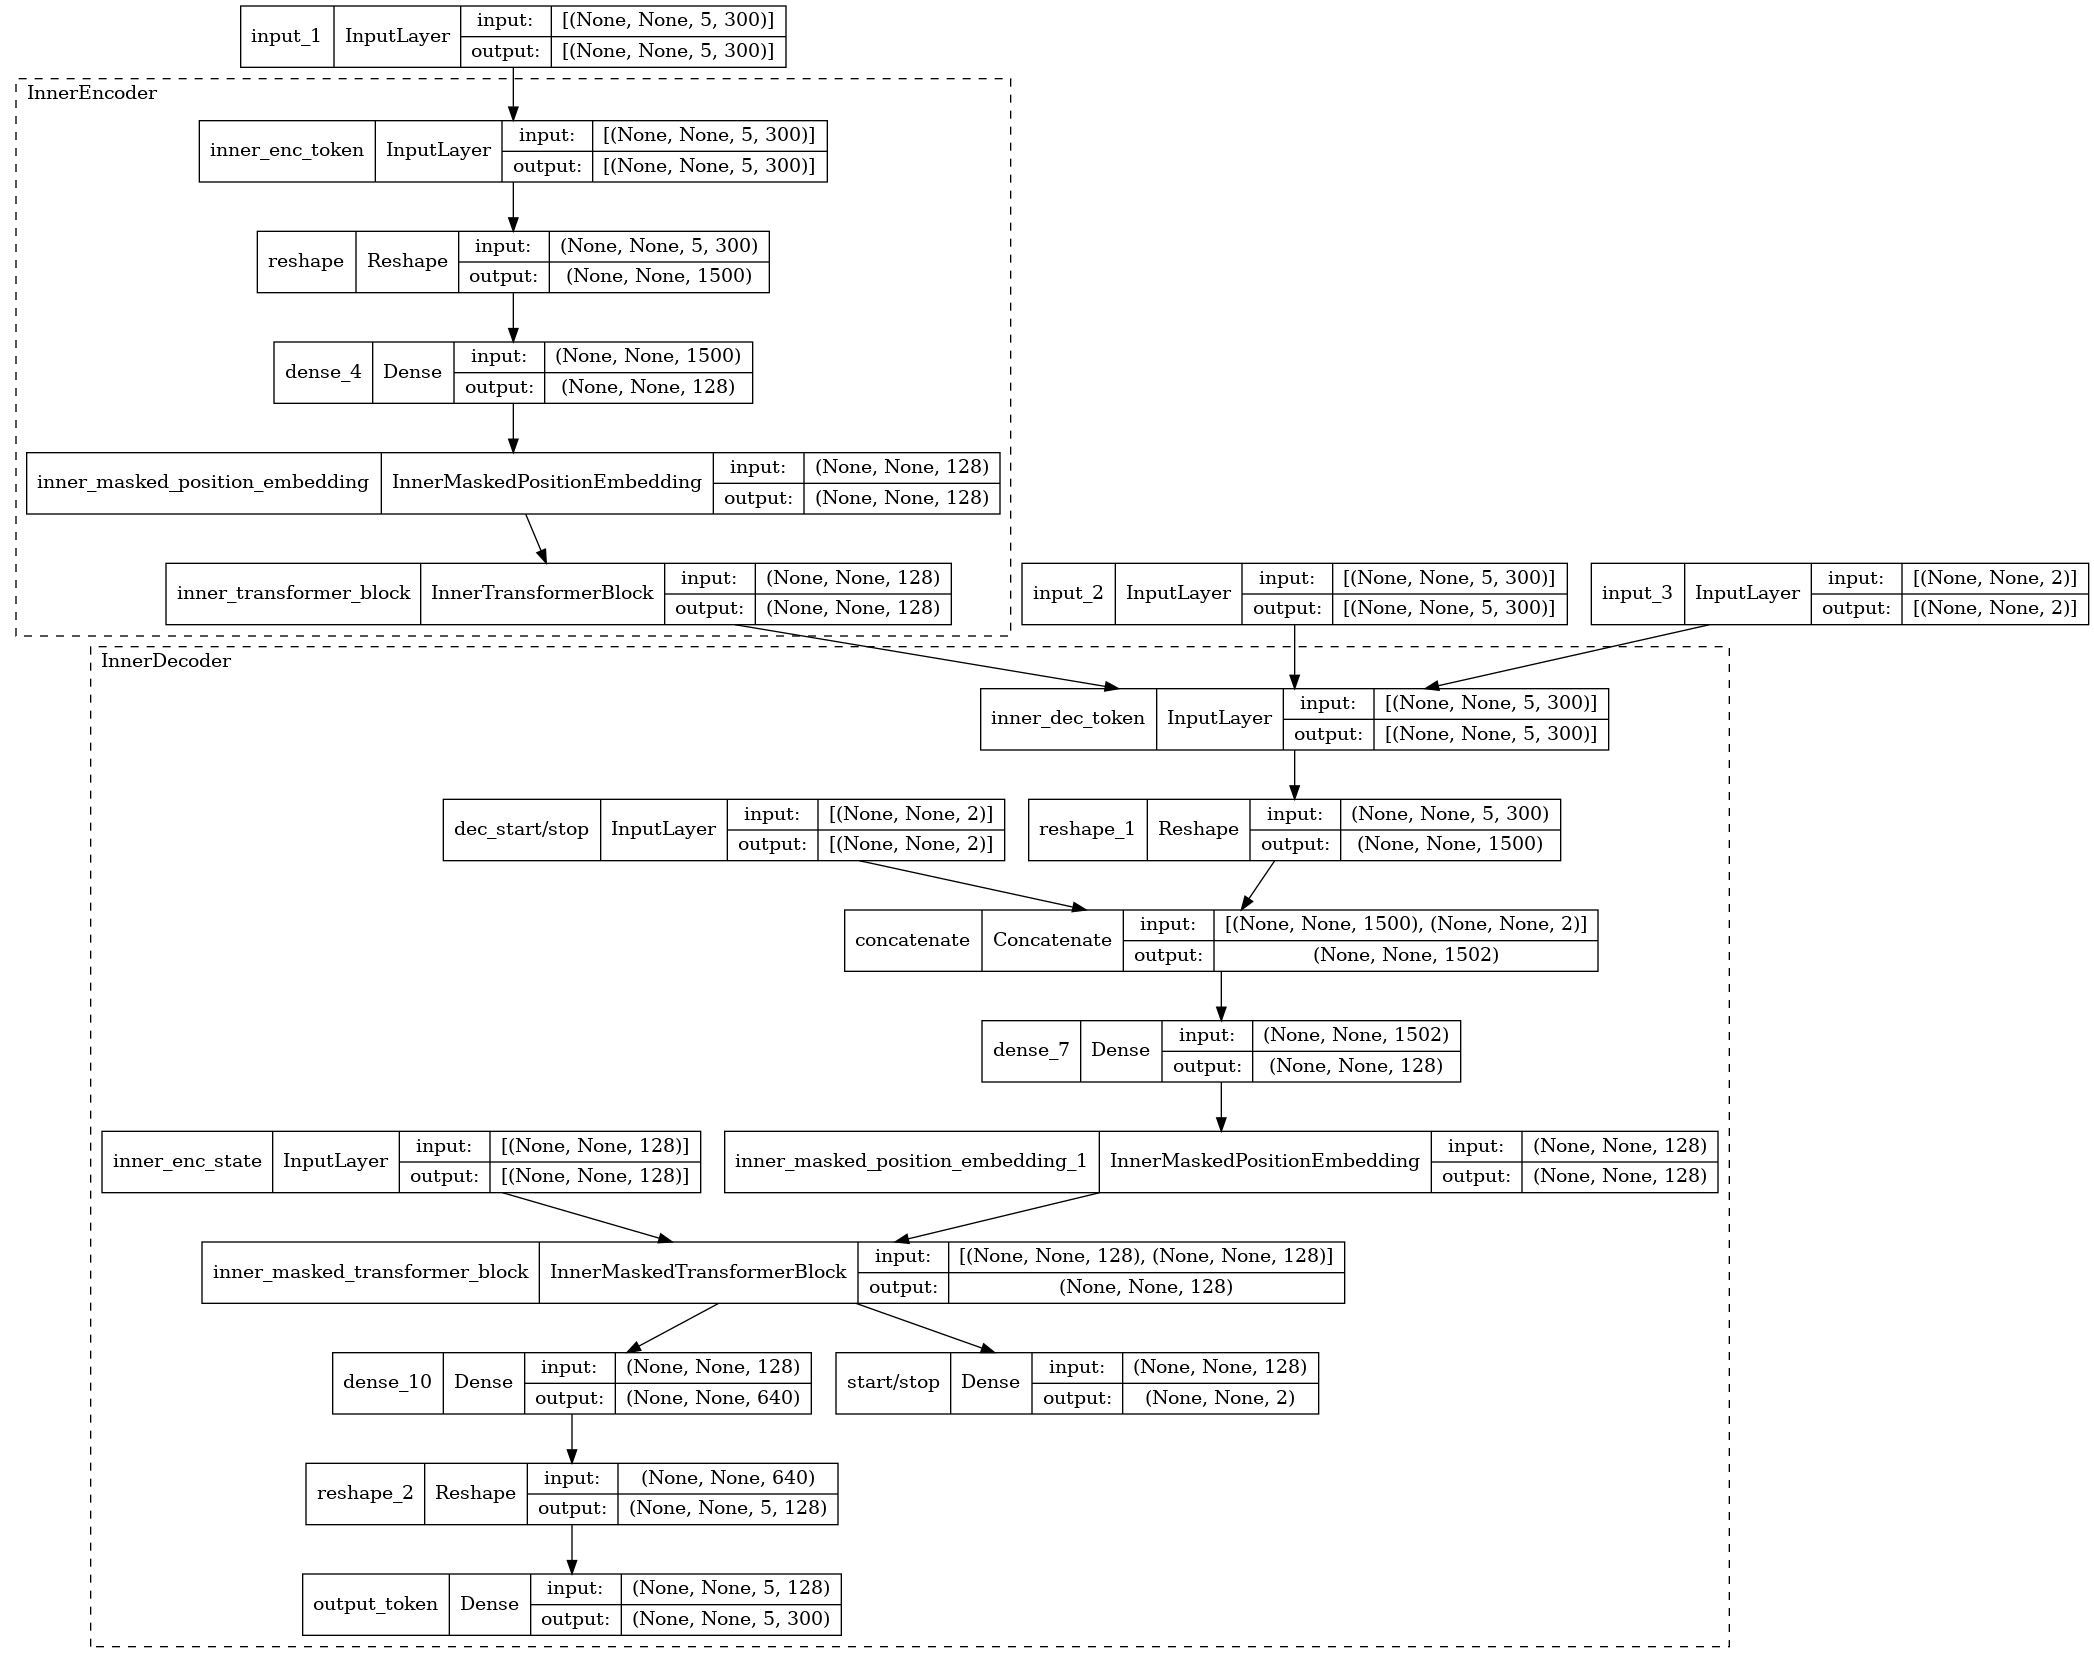

In [38]:
keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

# Get accuracy

In [ ]:
# --- Get accuracy ---
with strategy.scope():
    word_acc_arr = []
    letter_acc_arr = []
    for m in range(100):
        #get the context
        context = encoder_model.predict(inner_x_testing[m:m+1]) 
        #without teacher forcing

        input_tokens = np.zeros_like(inner_preY_testing[m:m+1])

        input_start = np.zeros_like(pre_start[m:m+1])

        input_start[0,0:1,:] = pre_start[0,0:1,:]

        for i in range(0,3):

            output_tokens = decoder_model.predict([context, input_tokens, input_start])

            input_tokens[:,i+1:i+2,:,:] = output_tokens[0][:,i:i+1,:,:] #replace on input_tokens timestep
            input_start[:,i+1:i+2,:] = output_tokens[1][:,i:i+1,:]
            #context = output_tokens[2:4]
        output_tokens = decoder_model.predict([context, input_tokens, input_start])

        arr = []

        for k in range(3):
            context = output_tokens[0][0][k:k+1,:,:]
            actual_context = inner_postY_testing[m][k:k+1,:,:]
            # Use this if you just want to test the outer decoder...
            context = actual_context
            i=0
            tokens = np.zeros_like(outer_preY[0:1])
            tokens[0:1,0:1] = outer_preY[0:1,0:1] # Start only...

            for j in range(5): #ouput length is 5+1
                result = np.argmax(outer_decoder.predict([tokens,context]),-1)
                tokens[0:1,j+1:j+2] = result[0:1, j:j+1]
            result = np.argmax(outer_decoder.predict([tokens,context]),-1)
            arr.append(int_to_letter(result, mapping)[0])

        output = np.asarray(arr)

        check = int_to_letter(outer_postY[testingSet_int[m]-1], mapping)

        word_acc_arr.append(word_accuracy(output, check))
        letter_acc_arr.append(letter_accuracy(output, check))



2022-07-31 19:23:08.689845: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_16032"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:283"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Y

In [ ]:
# use `model.metrics_names` to get indices for accuracy:
print('-----------------------------')
print('''   Generalization Accuracy
-----------------------------
word_accuracy: %f
letter_accuracy: %f
'''%(sum(word_acc_arr) / len(word_acc_arr) * 100, sum(letter_acc_arr) / len(letter_acc_arr) * 100))